In [ ]:
!pip install rasterio
!pip install pyrsgis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 91.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pyrsgis import raster # Raster Used for Open and import Data
from pyrsgis import ml
import random
from copy import copy
from itertools import cycle
from osgeo import gdal

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
S2 = rio.open("/content/drive/MyDrive/Sistan_Sentinel.tif")
S2_array = S2.read()

In [ ]:
GT = rio.open("/content/drive/MyDrive/Sistan_Sentinel_Training.tif")
GT_array = GT.read()

In [ ]:
print(S2_array.shape)#Image
print(GT_array.shape)#Ground Truth

(10, 866, 770)
(1, 866, 770)


In [ ]:
nRows = S2_array.shape[1]
nColumns = S2_array.shape[2]
nBands = S2_array.shape[0]
print(nRows)
print(nColumns)
print(nBands)

866
770
10


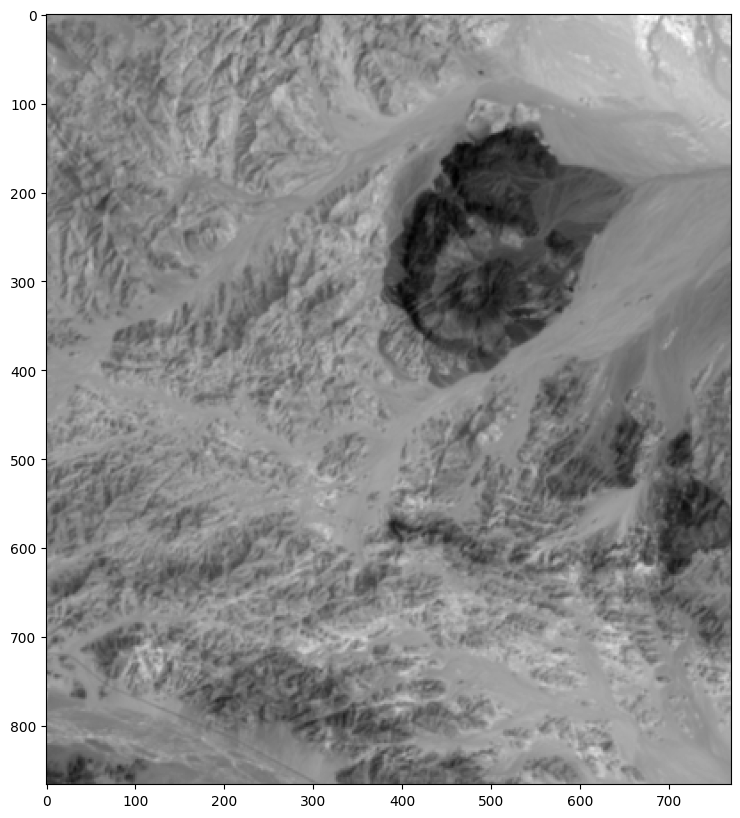

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(S2_array[8,:,:], cmap = 'gray')
plt.show()

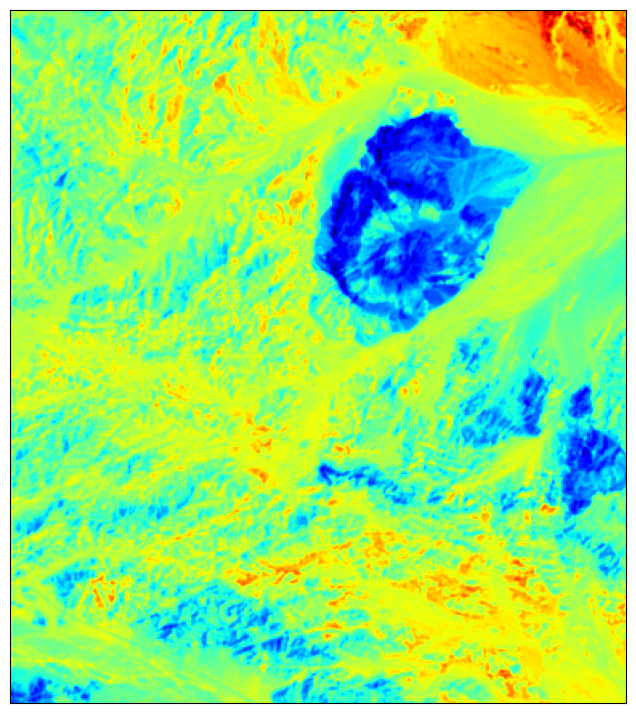

In [ ]:
plt.figure(figsize = (9,9))
plt.imshow(S2_array[8,:,:], cmap = 'jet')
plt.xticks([])
plt.yticks([])
plt.show()

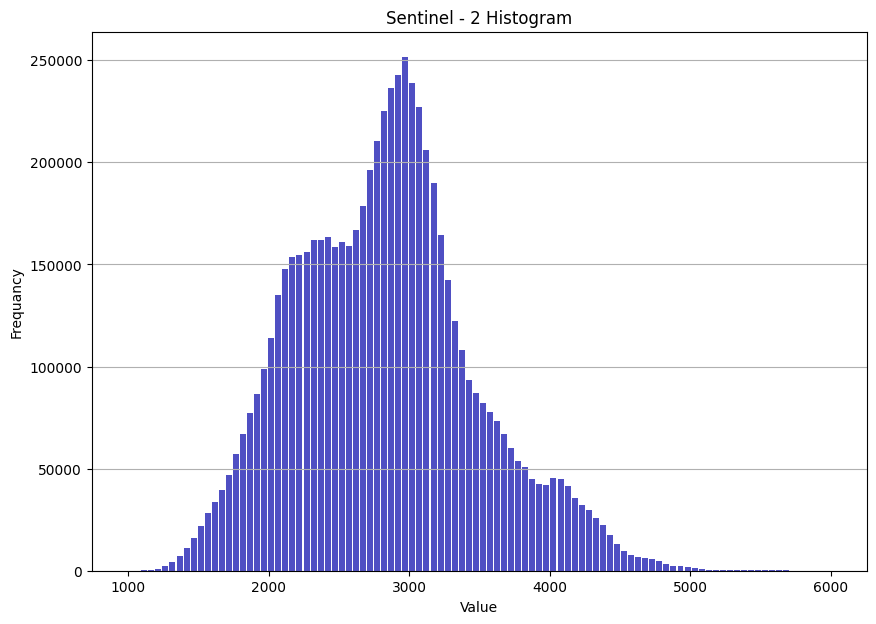

In [ ]:
plt.figure(figsize = (10,7))
plt.grid(axis='y', alpha = 1)
plt.xlabel('Value')
plt.ylabel('Frequancy')
plt.title('Sentinel - 2 Histogram')
n , bins, patches = plt.hist(x = S2_array.flatten(), bins = 100, color = '#0504aa',
                             alpha = 0.7, rwidth = 0.85)

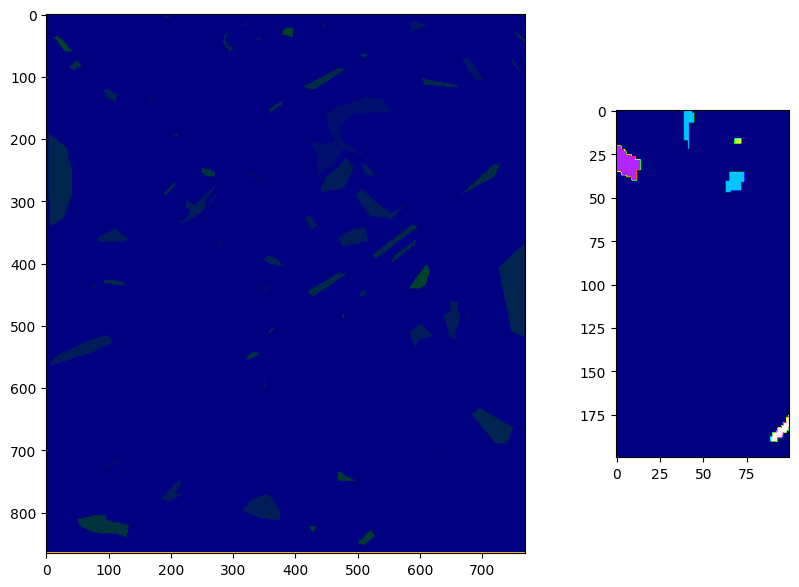

In [ ]:
fig = plt.figure(figsize=(13,7))
gs = fig.add_gridspec(1,5)
fig.add_subplot(gs[0,:3]), plt.imshow(GT_array[0,:,:], cmap = "gist_ncar")
fig.add_subplot(gs[0,-2]), plt.imshow(GT_array[0,100:300,100:200], cmap = "gist_ncar")
plt.show()

In [ ]:
list(np.unique(GT_array))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 255]

In [ ]:
GT_array[GT_array == 255] = 0
classes = np.unique(GT_array)
print(classes)

[0 1 2 3 4 5 6 7 8 9]


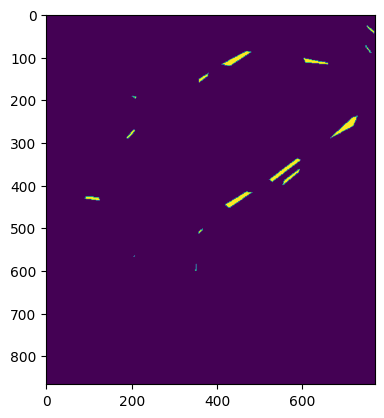

In [ ]:
c = 6
cls = np.zeros((nRows, nColumns), dtype = int)
cls[GT_array[0, :,:] == c] = 1

plt.figure()
plt.imshow(cls)
plt.show()

In [ ]:
print(classes)

[0 1 2 3 4 5 6 7 8 9]


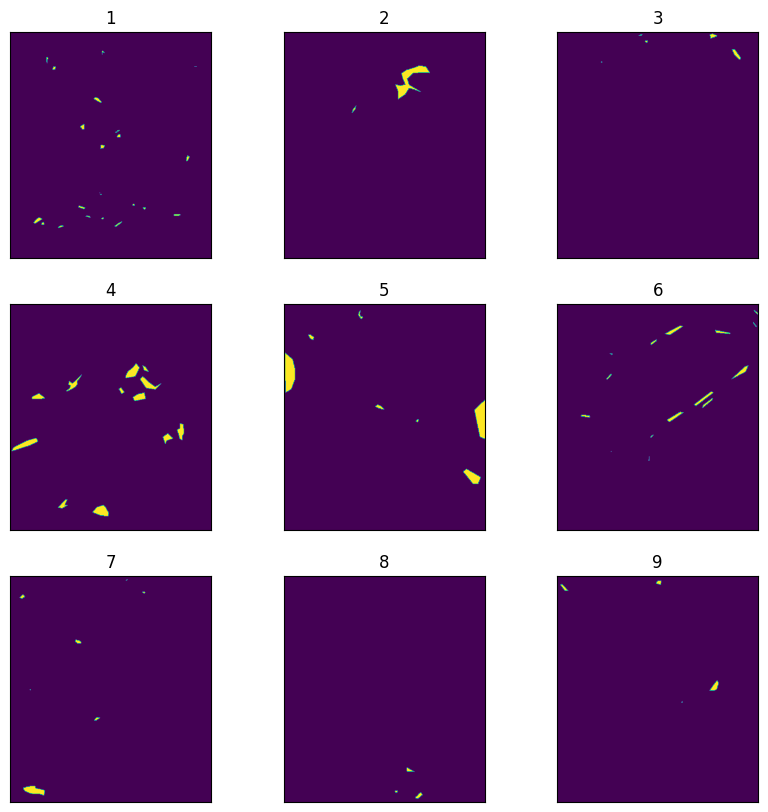

In [ ]:
plt.figure(figsize = (10,10))
plt.tight_layout()
for i in range(len(classes)):
  if i < 1 :
    continue
  C = np.zeros((nRows, nColumns))
  C[GT_array[0, :, :] == classes[i]] = 1
  plt.subplot(3,3,i)
  plt.title(str(classes[i]))
  plt.xticks([])
  plt.yticks([])
  plt.imshow(C)
plt.show()

In [ ]:
GT_array = GT_array[0,: ,:].astype(int)

In [ ]:
GT_array.shape

(866, 770)

In [ ]:
print(GT_array.shape)
print(GT_array.flatten().shape)
print(nRows * nColumns)

(866, 770)
(666820,)
666820


In [ ]:
GT_array.shape

(866, 770)

In [ ]:
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
for i in range(20):
  if i in classes:
    print(len(np.where(GT_array.flatten() == i)[0]))

628149
2294
4957
878
11245
11220
4051
2330
583
1113


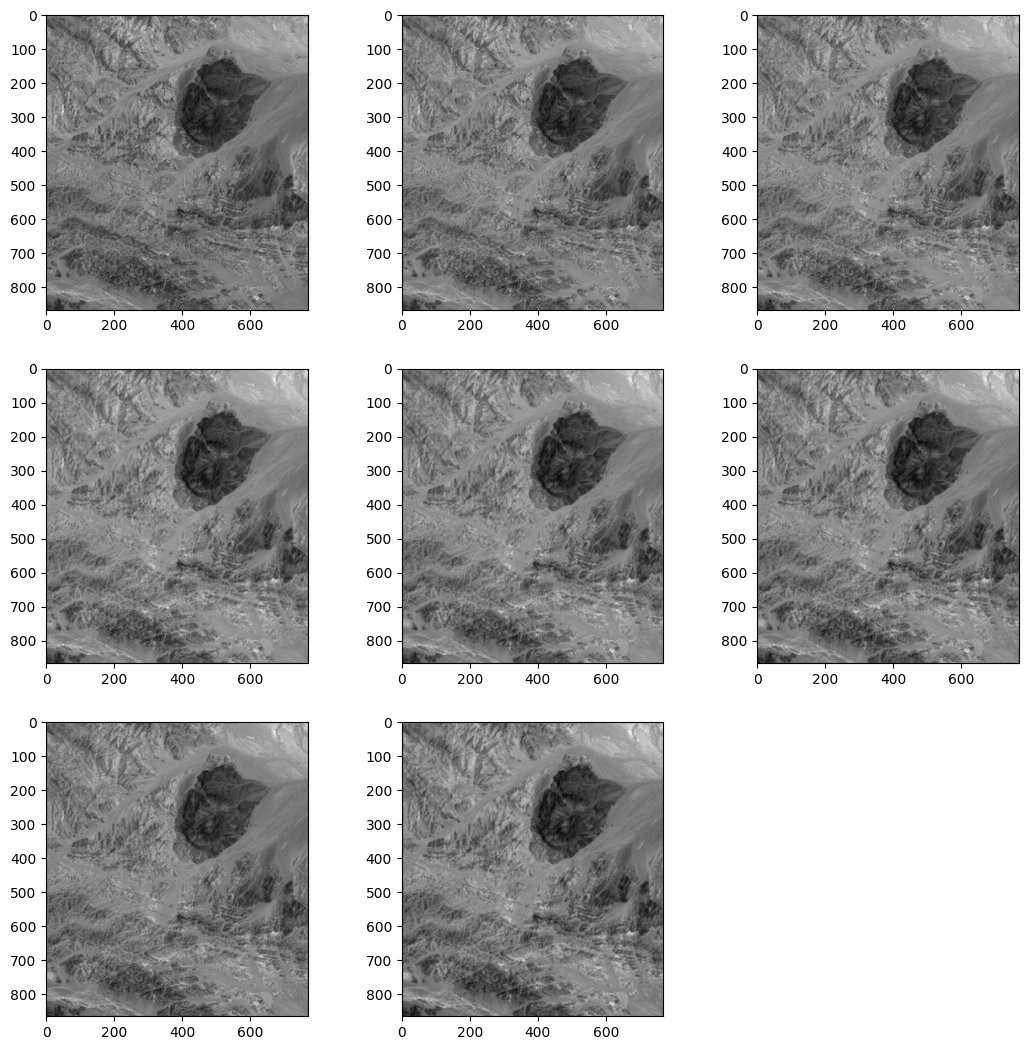

In [ ]:
plt.figure(figsize = (13,13))
plt.subplot(331), plt.imshow(S2_array[0, :, :], cmap='gray')
plt.subplot(332), plt.imshow(S2_array[1, :, :], cmap='gray')
plt.subplot(333), plt.imshow(S2_array[2, :, :], cmap='gray')
plt.subplot(334), plt.imshow(S2_array[3, :, :], cmap='gray')
plt.subplot(335), plt.imshow(S2_array[4, :, :], cmap='gray')
plt.subplot(336), plt.imshow(S2_array[5, :, :], cmap='gray')
plt.subplot(337), plt.imshow(S2_array[6, :, :], cmap='gray')
plt.subplot(338), plt.imshow(S2_array[7, :, :], cmap='gray')
plt.show()

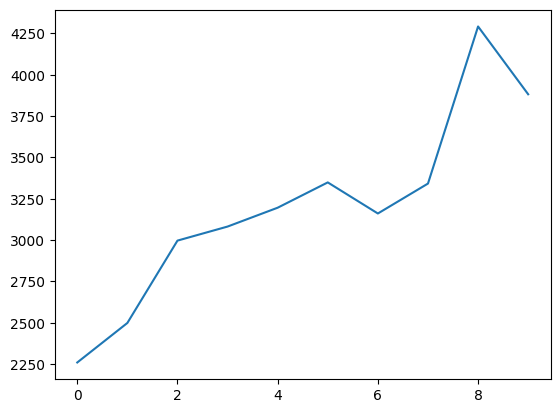

In [ ]:
plt.plot(S2_array[:, 200,300])

In [ ]:
featureFile = r'/content/drive/MyDrive/Sistan_Sentinel.tif'
labelFile = r'/content/drive/MyDrive/Sistan_Sentinel_Training.tif'

In [ ]:
dsFeature , arrFeature = raster.read(featureFile, bands = 'all')
arrFeature = arrFeature.astype(float)

In [ ]:
arrFeature.shape

(10, 866, 770)

In [ ]:
for i in range(arrFeature.shape[0]):
  bandMin = arrFeature[i][:][:].min()
  bandMax = arrFeature[i][:][:].max()
  bandRange = bandMax - bandMin
  for j in range(arrFeature.shape[1]):
    for k in range(arrFeature.shape[2]):
      arrFeature[i][j][k] = (arrFeature[i][j][k] - bandMin) / bandRange

In [ ]:
print(arrFeature)

[[[0.46893975 0.44932275 0.44278375 ... 0.6627744  0.65483419 0.66043905]
  [0.47127511 0.46426903 0.44698739 ... 0.66510976 0.68986455 0.70714619]
  [0.47501168 0.47501168 0.47080803 ... 0.67118169 0.67024755 0.69313405]
  ...
  [0.13498365 0.14152265 0.14432508 ... 0.46893975 0.46099953 0.45539468]
  [0.16160673 0.15600187 0.16907987 ... 0.45632882 0.4614666  0.45679589]
  [0.2176553  0.17888837 0.17141523 ... 0.45773003 0.46193368 0.46520318]]

 [[0.48655617 0.47918969 0.47255985 ... 0.70018416 0.69281768 0.68618785]
  [0.50018416 0.48139963 0.47992634 ... 0.69981584 0.71860037 0.72965009]
  [0.50276243 0.50165746 0.49576427 ... 0.71012891 0.70939227 0.72744015]
  ...
  [0.14511971 0.14732965 0.15653775 ... 0.50718232 0.50165746 0.49650092]
  [0.16574586 0.17274401 0.17826888 ... 0.50460405 0.49944751 0.49907919]
  [0.21915285 0.18858195 0.18895028 ... 0.50239411 0.50423573 0.49760589]]

 [[0.49627721 0.48654066 0.48940435 ... 0.73195876 0.72279496 0.72594502]
  [0.49828179 0.488831

In [ ]:
print(arrFeature.shape)

(10, 866, 770)


In [ ]:
features = ml.array_to_chips(arrFeature, x_size=7, y_size=7)

In [ ]:
features.shape

(666820, 7, 7, 10)

In [ ]:
dsLabels, arrLabels = raster.read(labelFile)

In [ ]:
np.unique(arrLabels)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 255], dtype=uint8)

In [ ]:
arrLabels[arrLabels == 255] = 0

In [ ]:
np.unique(arrLabels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
arrLabels = arrLabels.flatten()

In [ ]:
arrLabels.shape

(666820,)

In [ ]:
features = features[arrLabels != 0]
labels = arrLabels[arrLabels != 0]

In [ ]:
np.unique(labels)

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
features.shape

(38671, 7, 7, 10)

In [ ]:
def train_test_split(features, labels, trainProb = 0.70):
  dataSize = features.shape[0]
  sliceIndex = int(dataSize * trainProb)
  randIndex = np.arange(dataSize)
  random.shuffle(randIndex)
  train_x = features[[randIndex[:sliceIndex]],:,:, :][0]
  test_x = features[[randIndex[sliceIndex:]],:,:, :][0]
  train_y = labels[randIndex[:sliceIndex]]
  test_y = labels[randIndex[sliceIndex:]]
  return(train_x, test_x, train_y, test_y)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(features, labels)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(27069, 7, 7, 10)
(27069,)
(11602, 7, 7, 10)
(11602,)


In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size = 1, padding = 'valid', activation = 'relu',
                                 input_shape = (train_x.shape[1], train_x.shape[2], train_x.shape[3])))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(48, kernel_size = 1, padding = 'valid', activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 32)          352       
                                                                 
 dropout (Dropout)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 48)          1584      
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 48)          0         
                                                                 
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 64)                150592    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.fit(train_x, train_y, epochs = 20)

Epoch 1/20
846/846 [==============================] - 7s 6ms/step - loss: 0.8528 - accuracy: 0.7225
Epoch 2/20
846/846 [==============================] - 3s 4ms/step - loss: 0.4792 - accuracy: 0.8365
Epoch 3/20
846/846 [==============================] - 4s 5ms/step - loss: 0.3678 - accuracy: 0.8723
Epoch 4/20
846/846 [==============================] - 3s 4ms/step - loss: 0.3085 - accuracy: 0.8943
Epoch 5/20
846/846 [==============================] - 3s 4ms/step - loss: 0.2712 - accuracy: 0.9081
Epoch 6/20
846/846 [==============================] - 3s 4ms/step - loss: 0.2464 - accuracy: 0.9179
Epoch 7/20
846/846 [==============================] - 4s 5ms/step - loss: 0.2244 - accuracy: 0.9243
Epoch 8/20
846/846 [==============================] - 3s 4ms/step - loss: 0.2069 - accuracy: 0.9322
Epoch 9/20
846/846 [==============================] - 3s 4ms/step - loss: 0.1985 - accuracy: 0.9340
Epoch 10/20
846/846 [==============================] - 3s 4ms/step - loss: 0.1828 - accuracy: 0.9395

In [ ]:
dsPre , featurePre = raster.read(r'/content/drive/MyDrive/Sistan_Sentinel.tif')
featurePre = featurePre.astype(float)

In [ ]:
for i in range(arrFeature.shape[0]):
  bandMin = featurePre[i][:][:].min()
  bandMax = featurePre[i][:][:].max()
  bandRange = bandMax - bandMin
  for j in range(featurePre.shape[1]):
    for k in range(featurePre.shape[2]):
      featurePre[i][j][k] = (featurePre[i][j][k] - bandMin) / bandRange

In [ ]:
new_features = ml.array_to_chips(featurePre, x_size =7, y_size = 7)

In [ ]:
newPredicted = model.predict(new_features)

20839/20839 [==============================] - 27s 1ms/step


In [ ]:
prediction = np.reshape(newPredicted.argmax(axis =1), (dsPre.RasterYSize, dsPre.RasterXSize))

In [ ]:
outfile = r'/content/CNN.tif'
raster.export(prediction, dsPre, filename = outfile, dtype = 'float')

In [ ]:
cnn_map = prediction
print(cnn_map)

[[6 6 6 ... 7 7 7]
 [9 9 9 ... 7 7 7]
 [9 9 9 ... 7 7 7]
 ...
 [4 4 4 ... 8 8 8]
 [4 4 4 ... 8 8 8]
 [4 4 4 ... 8 8 8]]


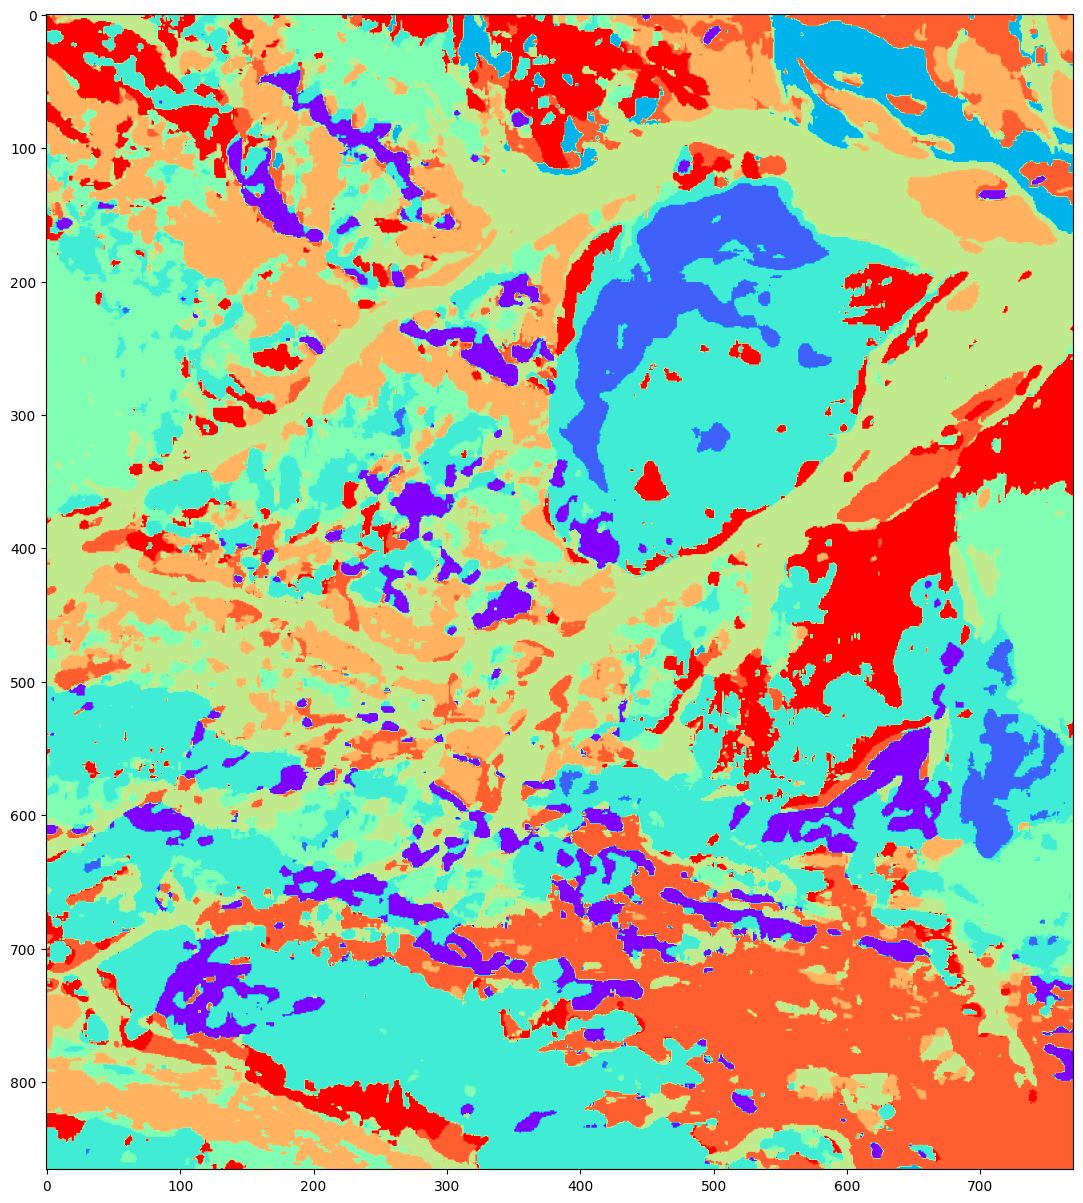

In [ ]:
plt.figure(figsize = (15,15))
plt.imshow(cnn_map, cmap = 'rainbow')
plt.show()

In [ ]:
# recall ------> تعداد مثبت های بازگردانده شده توسط مدل
# F1 -------> این امتیاز، میانگین هارمونیک از دقت و یادآوری را به ما می دهد.
# -------> بهترین مقدار برایش 1 و بدترین مقدار صفر است

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [ ]:
yTestPredicted = model.predict(test_x)

363/363 [==============================] - 1s 1ms/step


In [ ]:
y_score = yTestPredicted[:, 1:yTestPredicted.shape[1]]

In [ ]:
yTestPredicted = (yTestPredicted > 0.5).astype(int)

In [ ]:
cMatrix = confusion_matrix(test_y, yTestPredicted.argmax(axis =1))
pScore = precision_score(test_y, yTestPredicted.argmax(axis =1), average = 'micro')
rScore = recall_score(test_y, yTestPredicted.argmax(axis =1), average = 'micro')
fscore = f1_score(test_y, yTestPredicted.argmax(axis =1), average = 'micro')

In [ ]:
print("Confusion Matrix:\n",  cMatrix)

Confusion Matrix:
 [[   0    0    0    0    0    0    0    0    0    0]
 [   0  657    0    0    8    0    1    0    3    0]
 [   2    0 1436    0   30    8    0    0    0    0]
 [   0    0    0  235    0    0    0    0   10    0]
 [  16    0    0    0 3156  106    0    0    0   71]
 [   0    0    0    0    0 3375   15    0    0    0]
 [   1    0    0    7    0    3 1234    3    0    0]
 [   7    0    0    0    0    0    1  695    0    2]
 [   1    0    0    0    0    0    1    0  171    0]
 [   0    0    0    0    4    2    0    0    0  341]]


In [ ]:
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))



P-Score: 0.974, R-Score: 0.974, F-Score: 0.974


In [ ]:
import seaborn as sns

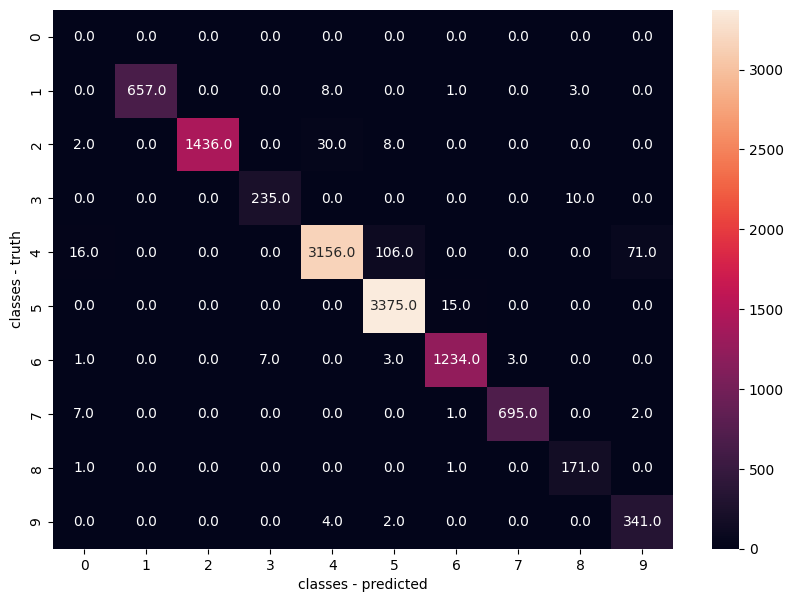

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(cMatrix, annot = True, fmt = ".1f")
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.show()

In [ ]:
from scipy import interp
from sklearn.metrics import roc_curve, auc

In [ ]:
n_classes = 9
fpr = dict()
tpr = dict()
roc_auc = dict()

In [ ]:
np.unique(labels)

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
from sklearn.preprocessing import label_binarize
test_y = label_binarize(test_y, classes = list(range(1, n_classes + 1)))

In [ ]:
np.unique(test_y)

array([0, 1])

In [ ]:
for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_score[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
fpr['micro'], tpr['micro'], _ = roc_curve(test_y.ravel(), y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

In [ ]:
fpr

{0: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 9.14662032e-05, 9.14662032e-05, 1.64639166e-03,
        1.64639166e-03, 1.01527486e-02, 1.01527486e-02, 1.29882009e-02,
        1.29882009e-02, 1.85676393e-02, 1.85676393e-02, 9.96707217e-01,
        1.00000000e+00]),
 1: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.000000

In [ ]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [ ]:
np.unique(all_fpr)

In [ ]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [ ]:
mean_tpr

In [ ]:
mean_tpr /= n_classes
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

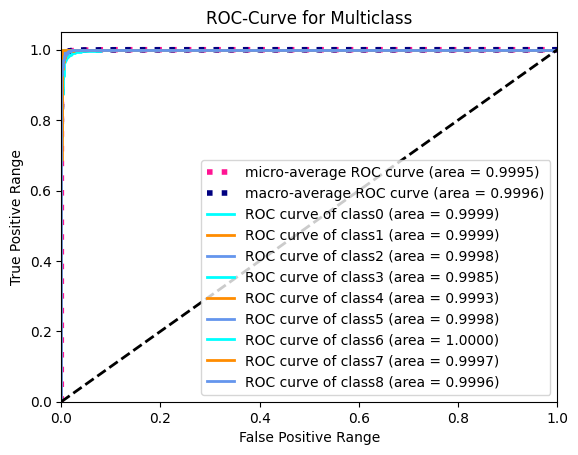

In [ ]:
plt.figure(1)
plt.plot(fpr['micro'], tpr['micro'],
         label = 'micro-average ROC curve (area = {0:0.4f})'
            ''.format(roc_auc['micro']),
         color = 'deeppink', linestyle = ':', linewidth = 4)

plt.plot(fpr['macro'], tpr['macro'],
         label = 'macro-average ROC curve (area = {0:0.4f})'
            ''.format(roc_auc['macro']),
         color = 'navy', linestyle = ':', linewidth = 4)

color = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), color):
  plt.plot(fpr[i], tpr[i], color = color, lw = 2,
           label = 'ROC curve of class{0} (area = {1:0.4f})'
           ''.format(i, roc_auc[i]))

plt.plot([0,1],[0,1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Range')
plt.ylabel('True Positive Range')
plt.title('ROC-Curve for Multiclass')
plt.legend(loc = "lower right")
plt.show()